In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score

# Классификация при помощи ДПР

# Описание набора данных

В этой лабораторной работе мы рассмотрим разные подходы к задаче классификации, в частности, деревья принятия решений, а также поговорим о том, как бороться с несбалансированностью датасета.

Изучаемый нами набор данных — это набор данных о принятых предложениях по кредитам в банке **Thera-Bank**. Основные клиенты банка пользуются банком для того, чтобы разместить в нем свои денежные средства, то есть являются вкладчиками. В то же время, большую прибыль банку приносят кредиторы — люди, берущие в банке кредит. Поэтому банк хочет сформировать для своих вкладчиков выгодные предложения по кредиту. Кампания, проведенная банком для вкладчиков в прошлом году, показала, что коэффициент конверсии составил более 9,6%. Это побудило отдел маркетинга разработать кампании с улучшенным целевым маркетингом, чтобы увеличить вероятность успеха при, естественно, минимальном бюджете. Департамент хотел бы разработать классификатор, который поможет им определить потенциальных клиентов, которые с большей вероятностью приобретут кредит. Это повысит вероятность успеха при одновременном снижении стоимости кампании.

Набор данных содержит как информацию о клиенте, так и информацию о его реакции на кампанию предыдущего года:

*   **ID**: ID клиента

*   **Age**: Возраст (полных лет)

*   **Experience**: Стаж

*   **Income**: Годовой доход (в тысячах)

*   **ZIP Code**: Индекс места проживания

*   **Family**: Количество членов семьи

*   **CCAvg**: Средние траты в месяц по кредитной карте (в тысячах)

*   **Education**: Уровень образования (1: бакалавр, 2: магистр, 3: что-то большее)

*   **Mortgage**: Стоимость ипотеки, если имеется (в тысячах)

*   **Securities Account**: Наличие счета в ценных бумагах

*   **CD Account**: Наличие сертификата на депозит

*   **Online**: Использует ли клиент интернет-банкинг

*   **CreditCard**: Использует ли клиент кредитную карту, выпущенную данным банком

*   **Personal Loan**: Принял ли клиент персональное предложение по кредиту (целевая переменная)

# Разведочный анализ данных

Считайте набор данных в датафрейм

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/DeepLearningCourse/Bank_Personal_Loan_Modelling_train.csv")

При помощи метода <code>.describe()</code> изучите набор данных «с высоты птичьего полета».

In [ ]:
df.describe()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.00000
mean,2497.682500,45.429500,20.196250,73.479750,93156.583750,2.381750,1.921805,1.881500,55.968250,0.096000,0.104000,0.061500,0.599000,0.29050
std,1449.723807,11.489235,11.500143,46.321345,2197.762636,1.149716,1.738974,0.842102,101.054887,0.294628,0.305299,0.240275,0.490162,0.45405
min,1.000000,23.000000,-3.000000,8.000000,9307.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,1245.750000,35.000000,10.000000,38.000000,91941.750000,1.000000,0.700000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,2492.500000,45.000000,20.000000,63.000000,93407.000000,2.000000,1.500000,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.00000
75%,3767.250000,55.000000,30.000000,98.000000,94608.000000,3.000000,2.500000,3.000000,100.000000,0.000000,0.000000,0.000000,1.000000,1.00000
max,5000.000000,67.000000,43.000000,224.000000,96651.000000,4.000000,10.000000,3.000000,635.000000,1.000000,1.000000,1.000000,1.000000,1.00000


Набор данных содержит 14 переменных, 1 из которых является целевой.

1 номинальная переменная: **ID**

5 числовых переменных: **Age**, **Experience**, **Income**, **CCAvg**, **Mortgage**

3 категориальные переменных: **Family**, **Education**, **ZIP Code**

5 булевых переменных: **Personal Loan**, **Securities Account**, **CD Account**, **Online**, **CreditCard**

Пропущенных значений нет.

Experience содержит какие-то отрицательные значения

Удалите колонку ID, она нам не понадобится

In [ ]:
df = df.loc[:, df.columns != "ID"]

Имеет смысл попробовать отловить каике-либо зависимости или их отсутствие.

Постройте матрицу корреляций

<Axes: >

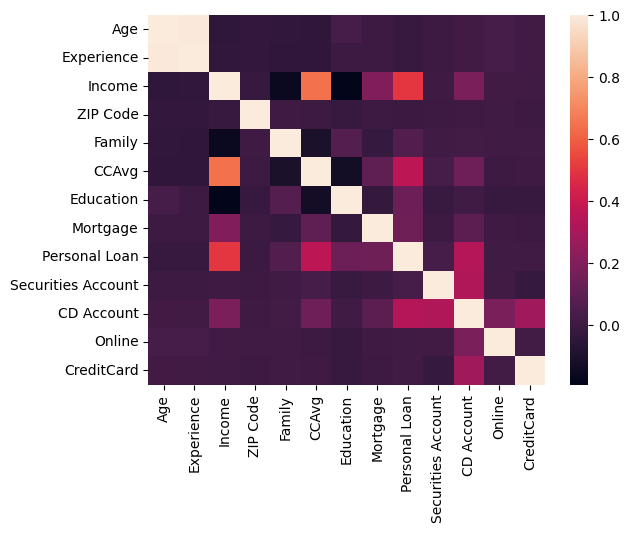

In [ ]:
sns.heatmap(df.corr())

Определите две наиболее коррелированных переменных

In [ ]:
df.corr().head(2)

,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
Age,1.000000,0.994134,-0.047440,-0.030978,-0.033864,-0.040827,0.027489,-0.003468,-0.018537,0.000950,0.013890,0.027305,0.014137
Experience,0.994134,1.000000,-0.037976,-0.029845,-0.040127,-0.038459,-0.001394,-0.000700,-0.018108,0.000239,0.016445,0.026962,0.015945


In [ ]:
# Age - Experience

Определите признак, который меньше всего коррелирует (можно считать почти не коррелирует) с остальными признаками (в том числе с откликом). Удалите этот признак из рассмотрения.

Введите название удаленного признака.

In [ ]:
dct_of_corrs = dict()
corr = df.corr()

for name in corr.columns:
  for name_ in corr.columns:
    if name_ not in dct_of_corrs.keys():
      dct_of_corrs[name_] = [name, abs(corr[name][name_])]
    elif dct_of_corrs[name_][1] > abs(corr[name_][name]):
      dct_of_corrs[name_] = [name, abs(corr[name][name_])]

dct_of_corrs

{'Age': ['Securities Account', 0.0009501616194431376],
 'Experience': ['Securities Account', 0.00023930933926668148],
 'Income': ['Securities Account', 0.005082360830093379],
 'ZIP Code': ['Securities Account', 0.0006666752609788317],
 'Family': ['ZIP Code', 0.006110294748150853],
 'CCAvg': ['ZIP Code', 0.003104102011525475],
 'Education': ['Experience', 0.001393778091528468],
 'Mortgage': ['Experience', 0.0006995442181042276],
 'Personal Loan': ['ZIP Code', 0.007605172939189681],
 'Securities Account': ['Experience', 0.00023930933926668148],
 'CD Account': ['ZIP Code', 0.008082135430378161],
 'Online': ['CCAvg', 0.0037184000190326138],
 'CreditCard': ['ZIP Code', 0.0014129991140908072]}

In [ ]:
dct_of_min_corrs = dict()

for key in dct_of_corrs.keys():
  if dct_of_corrs[key][0] not in dct_of_min_corrs.keys():
    dct_of_min_corrs[dct_of_corrs[key][0]] = 1
  else:
    dct_of_min_corrs[dct_of_corrs[key][0]] += 1

dct_of_min_corrs

{'Securities Account': 4, 'ZIP Code': 5, 'Experience': 3, 'CCAvg': 1}

In [ ]:
max = ('', 0)
for entry in dct_of_min_corrs.items():
  if max[1] < entry[1]:
    max = entry
max

('ZIP Code', 5)

In [ ]:
df = df.loc[:, df.columns != max[0]]
df

,Age,Experience,Income,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,60,36,89,2,2.8,1,0,0,0,0,1,0
1,44,19,30,1,0.5,3,0,0,0,0,1,0
2,26,0,19,1,0.1,2,121,0,0,0,1,0
3,34,9,41,2,0.1,1,161,0,0,0,1,1
4,56,32,51,4,1.5,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3995,37,11,59,4,0.2,3,0,0,0,0,0,0
3996,36,10,91,1,1.5,3,289,0,0,0,1,0
3997,57,31,131,2,2.7,1,0,0,0,0,0,0
3998,40,15,83,1,1.0,3,0,0,0,0,0,0


# Предварительная подготовка данных

## Модификация признаков

Стоит разобраться с полем <code>Experience</code>. Видно, что опыт коррелирует с возрастом. Однако, в поле <code>Experience</code> присутствуют отрицательные значения. Имеет смысл "сдвинуть" значения в этой колонке. Добавьте ко всем значениям колонки <code>Experience</code> одно число так, чтобы минимальное значение было равно $0$.

Вычислите выборочное среднее колонки <code>Experience</code> после преобразования.

In [ ]:
df['Experience'] -= min(df['Experience'])

In [ ]:
round(df['Experience'].mean(), 3)

23.196

Аналогично имеет смысл модфицировать поле <code>CCAvg</code>. Раз рассматривается годовой доход, то имеет смысл и значения трат рассматривать в рамках года.

Вычислите выборочное среднее колонки <code>CCAvg</code> после преобразования.

In [ ]:
df['CCAvg'] *= 12

In [ ]:
round(df['CCAvg'].mean(), 3)

23.062

## Определение выбросов

Постройте ящики с усами для всех предикторов. Рекомендуем использовать <code>sns.boxplot()</code>. Определите признак по изображению boxplot из вашего варианта.

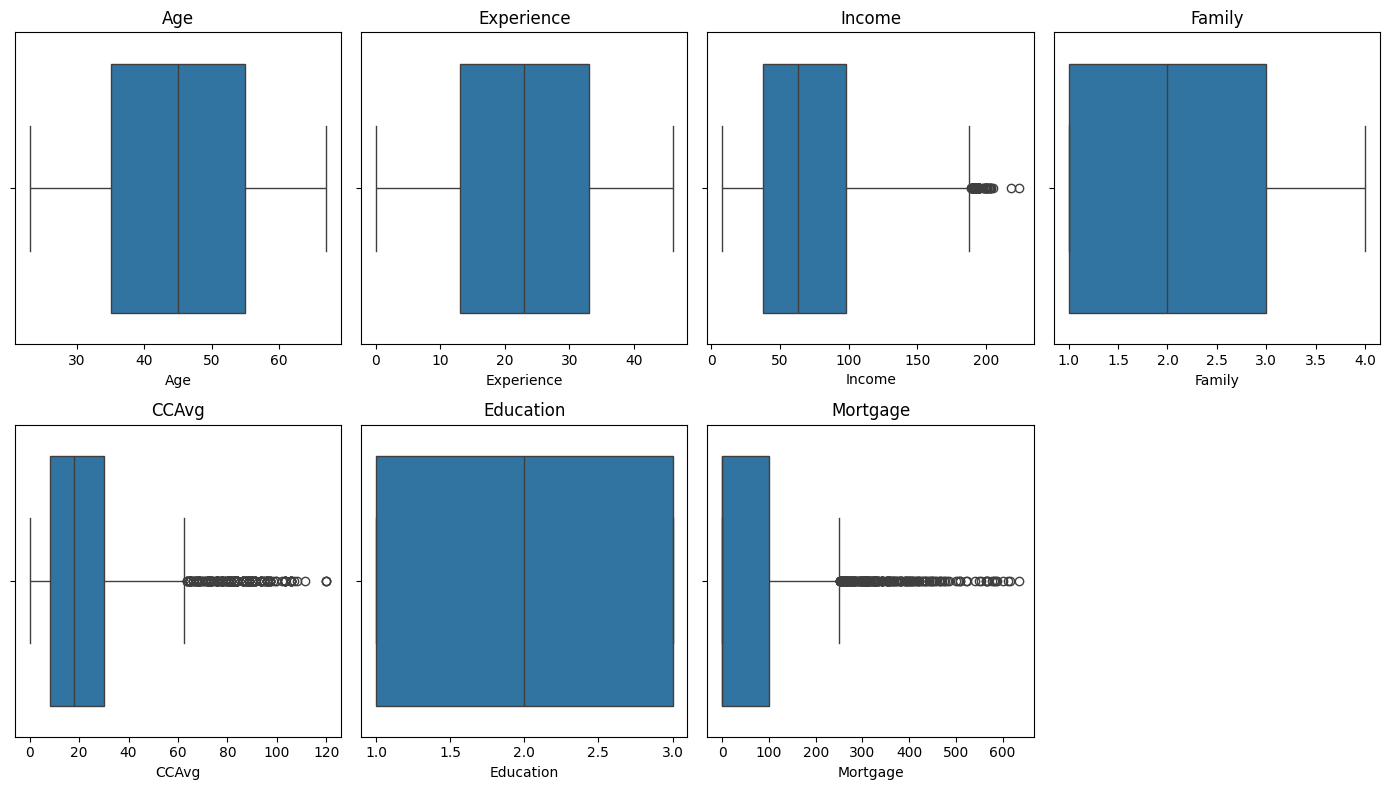

In [ ]:
predictors = ["Age", "Experience", "Income", "Family", "CCAvg", "Education", "Mortgage"]

plt.figure(figsize=(14, 8))
for i, column in enumerate(predictors, 1):
    plt.subplot(2, 4, i)
    sns.boxplot(x=df[column])
    plt.title(column)

plt.tight_layout()
plt.show()

Определите признак, содержащий наибольшее число выбросов. Введите название этого признака.


In [ ]:
outlier_counts = {}
for column in predictors:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    print(f"Column name: {column}; lower bound: {lower_bound}; upper bound: {upper_bound}.")
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    print(outliers.shape)
    outlier_counts[column] = len(outliers)


Column name: Age; lower bound: 5.0; upper bound: 85.0.
(0, 12)
Column name: Experience; lower bound: -17.0; upper bound: 63.0.
(0, 12)
Column name: Income; lower bound: -52.0; upper bound: 188.0.
(70, 12)
Column name: Family; lower bound: -2.0; upper bound: 6.0.
(0, 12)
Column name: CCAvg; lower bound: -24.000000000000007; upper bound: 62.400000000000006.
(255, 12)
Column name: Education; lower bound: -2.0; upper bound: 6.0.
(0, 12)
Column name: Mortgage; lower bound: -150.0; upper bound: 250.0.
(233, 12)


## Ответ с какого-то перепугу оказался Mortgage???

In [ ]:
max_outliers = ('', 0)
for entry in outlier_counts.items():
  if max_outliers[1] < entry[1]:
    max_outliers = entry

print(f"Признак с наибольшим числом выбросов: {max_outliers[0]} ({max_outliers[1]} выбросов)")

Признак с наибольшим числом выбросов: CCAvg (255 выбросов)


Имеет смысл поработать с этим признаком, а для этого стоит руководствоваться следующими статистическими соображениями. Если вычесть из данных выборочное среднее, а после поделить на среднеквадратическое отклонение, то, пользуясь правилом 3-$\sigma$ для нормального распределения, можно выбросить слишком далекие от нуля хвосты. Постройте гистограмму распределения значений в рамках этого признака.

In [ ]:
# Нормализация признака Mortgage
mortgage_mean = df["Mortgage"].mean()
mortgage_std = df["Mortgage"].std()
df["Mortgage_normalized"] = (df["Mortgage"] - mortgage_mean) / mortgage_std

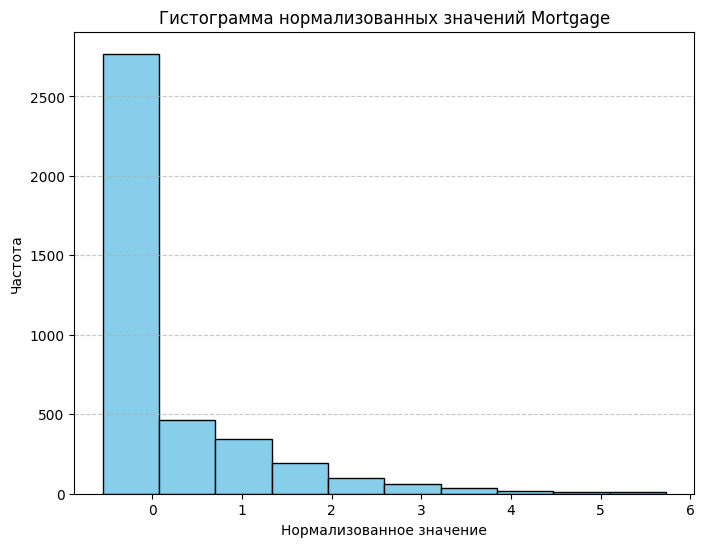

In [ ]:
# Построение гистограммы распределения нормализованных значений Mortgage
plt.figure(figsize=(8, 6))
plt.hist(df["Mortgage_normalized"], bins=10, color='skyblue', edgecolor='black')
plt.title("Гистограмма нормализованных значений Mortgage")
plt.xlabel("Нормализованное значение")
plt.ylabel("Частота")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Очевидно в рамках этого признака есть небольшое количество значений, которые лежат далеко. Можно использовать <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.zscore.html"><code>z-score</code></a> функцию из библиотеки <code>scipy</code>.

Вспомнив курс теории вероятностей, становится понятно, что около $99.7\%$ нормального распределения сождержатся в отрезке $[-3\sigma, 3\sigma]$. Определите число элементов, модуль <code>z-score</code> которых больше, чем $3$.

In [ ]:
# Вычисление Z-оценок для признака Mortgage
mortgage_z_scores = zscore(df["Mortgage_normalized"])
outliers_z_score = (abs(mortgage_z_scores) > 3).sum()
print(f"Число элементов, модуль Z-оценки которых больше 3: {outliers_z_score}")

Число элементов, модуль Z-оценки которых больше 3: 83


Итак, выбросов не очень множко, поэтому выбросите их из набора данных. Введите оставшееся в датасете число строк.

In [ ]:
# Удаление выбросов по Z-оценкам
filtered_df = df[abs(mortgage_z_scores) <= 3]
print(f"Число строк в оставшемся наборе данных: {len(filtered_df)}")

Число строк в оставшемся наборе данных: 3917


In [ ]:
filtered_df = filtered_df.loc[:, filtered_df.columns != 'Mortgage_normalized']
filtered_df

,Age,Experience,Income,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,60,39,89,2,33.6,1,0,0,0,0,1,0
1,44,22,30,1,6.0,3,0,0,0,0,1,0
2,26,3,19,1,1.2,2,121,0,0,0,1,0
3,34,12,41,2,1.2,1,161,0,0,0,1,1
4,56,35,51,4,18.0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3995,37,14,59,4,2.4,3,0,0,0,0,0,0
3996,36,13,91,1,18.0,3,289,0,0,0,1,0
3997,57,34,131,2,32.4,1,0,0,0,0,0,0
3998,40,18,83,1,12.0,3,0,0,0,0,0,0


# Построение моделей

# Базовый алгоритм

При помощи <code>train_test_split</code> разобейте полученный набор данных на тренеровочную и тестовую выборки с параметрами, указанными в вашем варианте.

In [ ]:
# Разделение данных на обучающую и тестовую выборки
X = filtered_df.loc[:, filtered_df.columns != "Personal Loan"]
y = filtered_df["Personal Loan"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=25, stratify=y)

Обучите модель <code>DecisionTreeClassifier</code> с параметрами, указанными в вашем варианте на тренировочных данных, оцените на тестовых. Вычислите <code>f1_score</code> модели на тестовых данных.

### Gini case

In [ ]:
# Обучение модели DecisionTreeClassifier
model = DecisionTreeClassifier(random_state=25, criterion='gini')
model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=25)

In [ ]:
# Оценка модели на тестовых данных
y_pred = model.predict(X_test)
score = f1_score(y_test, y_pred, average='binary')
print(f"F1-Score модели на тестовых данных: {round(score, 3)}")

F1-Score модели на тестовых данных: 0.897


### Entropy case

In [ ]:
# Обучение модели DecisionTreeClassifier
model = DecisionTreeClassifier(random_state=25, criterion='entropy')
model.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=25)

In [ ]:
# Оценка модели на тестовых данных
y_pred = model.predict(X_test)
score = f1_score(y_test, y_pred, average='binary')
print(f"F1-Score модели на тестовых данных: {round(score, 3)}")

F1-Score модели на тестовых данных: 0.917


## Учет дисбаланса соотношения классов

Обучите модель <code>DecisionTreeClassifier()</code> на тренировочном наборе данных со следующими параметрами: <code>random_state=41</code>, <code>criterion='gini'</code>, <code>class_weight='balanced'</code>. Оцените модель на тестовых данных.

In [ ]:
# Обучение модели DecisionTreeClassifier
model = DecisionTreeClassifier(random_state=25, criterion='gini', class_weight='balanced')
model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', random_state=25)

In [ ]:
# Оценка модели на тестовых данных
y_pred = model.predict(X_test)
score = f1_score(y_test, y_pred, average='binary')
print(f"F1-Score модели на тестовых данных: {round(score, 3)}")

F1-Score модели на тестовых данных: 0.941


Обучите модель <code>DecisionTreeClassifier()</code> на тренировочном наборе данных со следующими параметрами: <code>random_state=41</code>, <code>criterion='entropy'</code>, <code>class_weight='balanced'</code>. Оцените модель на тестовых данных.

In [ ]:
# Обучение модели DecisionTreeClassifier
model = DecisionTreeClassifier(random_state=41, criterion='entropy', class_weight='balanced')
model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       random_state=41)

In [ ]:
# Оценка модели на тестовых данных
y_pred = model.predict(X_test)
score = f1_score(y_test, y_pred, average='binary')
print(f"F1-Score модели на тестовых данных: {round(score, 3)}")

F1-Score модели на тестовых данных: 0.933


## Upsampling обучающей выборки

Помимо очевидного присвоения весов несбалансированным классам, можно воспользоваться алгоритмом <code>SMOTE</code>. Ему на вход подаются экземпляры всех классов с их метками, а он в свою очередь пытается на их основе экстраполировать само распределение данных этого класса. После этого он сэмплирует новые объекты классов так, пока количество строк каждого класса не станет везде одинаковым.

Получается, что в таком случае будет получена сбалансированная выборка, и пропадет нужда как-то ухищряться с весами и прочим.

Определите долю элементов класса $0$ тренировочного набора данных.

In [ ]:
round((len(y_train) - y_train.sum()) / len(y_train), 3)

0.911

Используя класс <a href="https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html"><code>SMOTE</code></a> из модуля <code>imblearn.over_sampling</code> сбалансируйте обучающую выборку с параметрами, указанными в вашем варианте.

In [ ]:
sm = SMOTE(random_state=25)
X_res, y_res = sm.fit_resample(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Убедитесь, что теперь в выборке содержится одинаковое число представителей обоих классов. Введите количество объектов класса $1$.

In [ ]:
y_res.sum()

2855

Снова обучите модель <code>DecisionTreeClassifier</code> с параметрами, указанными в вашем варианте на тренировочных данных, оцените на тестовых. Вычислите <code>f1_score</code> модели на тестовых данных.

Обучите модель <code>DecisionTreeClassifier()</code> на тренировочном наборе данных после upsampling'а со следующими параметрами: <code>random_state=41</code>, <code>criterion='gini'</code>. Оцените модель на тестовых данных.

In [ ]:
# Обучение модели DecisionTreeClassifier
model = DecisionTreeClassifier(random_state=25, criterion='gini')
model.fit(X_res, y_res)

DecisionTreeClassifier(random_state=41)

In [ ]:
# Оценка модели на тестовых данных
y_pred = model.predict(X_test)
score = f1_score(y_test, y_pred, average='binary')
print(f"F1-Score модели на тестовых данных: {round(score, 3)}")

F1-Score модели на тестовых данных: 0.863


Обучите модель <code>DecisionTreeClassifier()</code> на тренировочном наборе данных после upsampling'а со следующими параметрами: <code>random_state=41</code>, <code>criterion='entropy'</code>. Оцените модель на тестовых данных.

In [ ]:
# Обучение модели DecisionTreeClassifier
model = DecisionTreeClassifier(random_state=25, criterion='entropy')
model.fit(X_res, y_res)

DecisionTreeClassifier(criterion='entropy', random_state=25)

In [ ]:
# Оценка модели на тестовых данных
y_pred = model.predict(X_test)
score = f1_score(y_test, y_pred, average='binary')
print(f"F1-Score модели на тестовых данных: {round(score, 3)}")

F1-Score модели на тестовых данных: 0.854


# Задание 2


In [ ]:
df_test = pd.read_csv("/content/drive/MyDrive/DeepLearningCourse/Bank_Personal_Loan_Modelling_reserved.csv")

X_test = df_test.loc[:, df_test.columns != "ID"]
X_test = X_test.loc[:, X_test.columns != "ZIP Code"]

X_test

,Age,Experience,Income,Family,CCAvg,Education,Mortgage,Securities Account,CD Account,Online,CreditCard
0,64,39,23,3,0.5,1,0,1,0,0,0
1,33,9,184,2,4.8,2,0,0,0,0,0
2,58,33,22,3,0.2,1,0,0,0,1,0
3,54,24,61,4,2.0,3,0,1,0,1,0
4,55,29,49,2,0.8,3,220,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
995,49,23,58,4,2.6,1,188,0,0,0,0
996,32,6,78,1,2.9,3,0,0,0,0,0
997,52,28,31,4,0.2,1,141,0,0,1,1
998,32,7,54,4,1.3,1,0,1,0,1,0


In [ ]:
sm = SMOTE(random_state=25)
X_res, y_res = sm.fit_resample(X_res, y_res)

model = DecisionTreeClassifier(random_state=25, criterion='gini')
model.fit(X_res, y_res)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


DecisionTreeClassifier(random_state=11)

In [ ]:
y_pred = model.predict(X_test)

print(list(y_pred))

[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 